In [1]:
import warnings
warnings.filterwarnings("ignore")

# Clustering & Regionalization
<!--
**NOTE**: parts of this notebook have been
borrowed from [GDS'17 - Lab
6](http://darribas.org/gds17/content/labs/lab_06.html)
-->

In [2]:
from esda.moran import Moran
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN
import seaborn 
import pandas
import geopandas 
import numpy
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

## Introduction

The world's hardest questions are complex and multi-faceted.
Effective methods to learn from data should recognize this. Many questions
and challenges are inherently multidimensional; they are affected, shaped, and
defined by many different components all acting simultaneously. In statistical
terms, these processes are called *multivariate processes*, as opposed to 
*univariate processes*, where only a single variable acts at once.
Clustering is a fundamental method of geographical analysis that draws insights
from large, complex multivariate processes. It works by finding similarities among the
many dimensions in a multivariate process, condensing them down into a simpler representation
Thus, through clustering, a complex and difficult to understand process is recast into a simpler one
that even non-technical audiences can look at and understand. 

Often, clustering involves sorting observations into groups. For these groups to be more
meaningful than any single initial dimension, members of a group should be more
similar to one another than they are to members of a different group.
Each group is referred to as a *cluster* while the process of assigning
objects to groups is known as *clustering*. If done well, these clusters can be
characterized by their *profile*, a simple summary of what members of a group
are like in terms of the original multivariate process.

Since a good cluster is more
similar internally than it is to any other cluster, these cluster-level profiles
provide a convenient shorthand to describe the original complex multivariate process.
Observations in one group may have consistently high 
scores on some traits but low scores on others. 
The analyst only needs to look at the profile of a cluster in order to get a
good sense of what all the observations in that cluster are like, instead of
having to consider all of the complexities of the original multivariate process at once. 
Throughout data science, and particularly in geographic data science, 
clustering is widely used to provide insights on the
geographic structure of complex multivariate spatial data. 

In the context of explicitly spatial questions, a related concept, the *region*,
is also instrumental. A *region* is similar to a *cluster*, in the sense that
all members of a region have been grouped together, and the region should provide 
a shorthand for the original data. 
Further, for a region to be analytically useful, its members also should
display stronger similarity to each other than they do to the members of other regions. 
However, regions are more complex than clusters because they combine this
similarity in profile with additional information about the geography of their members.
In short, regions are like clusters (since they have a coherent profile), but they
also have a coherent geography&mdash;members of a region should also be
located near one another.

The process of creating regions is called regionalization.
A regionalization is a special kind of clustering where the objective is 
to group observations which are similar in their statistical attributes,
but also in their spatial location. In this sense, regionalization embeds the same
logic as standard clustering techniques, but also applies a series of
spatial and/or geographical constraints. Often, these
constraints relate to connectivity: two candidates can only be grouped together in the
same region if there exists a path from one member to another member
that never leaves the region. These paths often model the spatial relationships
in the data, such as contiguity or proximity. However, connectivity does not
always need to hold for all regions, and in certain contexts it makes
sense to relax connectivity or to impose different types of spatial constraints. 

In this chapter we consider clustering techniques and regionalization methods which will
allow us to do exactly that. In the process, we will explore the characteristics
of neighborhoods in San Diego.
We will extract common patterns from the
cloud of multidimensional data that the Census Bureau produces about small areas
through the American Community Survey. We begin with an exploration of the
multivariate data about San Diego by suggesting some ways to examine the 
statistical and spatial distribution of the data before carrying out any
 clustering. Focusing on the individual variables, as well as their pairwise
associations, can help guide the subsequent application of clusterings or regionalizations. 

We then consider geodemographic approaches to clustering&mdash;the application
of multivariate clustering to spatially referenced demographic data.
Two popular clustering algorithms are employed: k-means and Ward's hierarchical method.
Mapping the spatial distribution of the resulting clusters 
reveals interesting insights on the socioeconomic structure of the San Diego
metropolitan area. We also see that in many cases, clusters are spatially 
fragmented. That is, a cluster may actually consist of different areas that are not
spatially connected. Indeed, some clusters will have their members strewn all over the map. 
This will illustrate why connectivity might be important when building insight
about spatial data, since these clusters will not at all provide intelligible regions. 
So, we then will move on to regionalization, exploring different approaches that
incorporate geographical constraints into the exploration of the social structure of San Diego.

## Data

The dataset we will use in this chapter comes from the American Community Survey
(ACS). In particular, we examine data at the Census Tract level in San Diego,
California in 2017. Let us begin by reading in the data as a GeoDataFrame and
exploring the attribute names.

In [3]:
# Read file
db = geopandas.read_file('../data/sandiego/sandiego_tracts.gpkg')
# Print column names
db.columns

Index(['GEOID', 'median_age', 'total_pop', 'total_pop_white', 'tt_work',
       'hh_total', 'hh_female', 'total_bachelor', 'median_hh_income',
       'income_gini', 'total_housing_units', 'total_rented', 'median_no_rooms',
       'median_house_value', 'NAME', 'state', 'county', 'tract', 'area_sqm',
       'pct_rented', 'pct_hh_female', 'pct_bachelor', 'pct_white', 'sub_30',
       'geometry'],
      dtype='object')

To make things easier later on, let us collect the variables we will use to
characterize Census tracts. These variables capture different aspects of the socio-
economic reality of each area and, taken together, they provide a comprehensive
characterization of San Diego as a whole:

In [4]:
cluster_variables =  [
    'median_house_value', # Median house value
    'pct_white',          # Percent of tract population that is white
    'pct_rented',         # Percent of households that are rented
    'pct_hh_female',      # Percent of female-led households 
    'pct_bachelor',       # Percent of tract population with a Bachelors degree
    'median_no_rooms',    # Median number of rooms in the tract's households
    'income_gini',        # Gini index measuring tract wealth inequality
    'median_age',         # Median age of tract population
    'tt_work'             # Travel time to work 
]

### Exploring the data

Now let's start building up our understanding of this
dataset through both visual and summary statistical measures.

We will start by
looking at the spatial distribution of each variable alone.
This will help us draw a picture of the multi-faceted view of the tracts we
want to capture with our clustering. Let's use choropleth maps for the
nine attributes and compare these choropleth maps side-by-side:

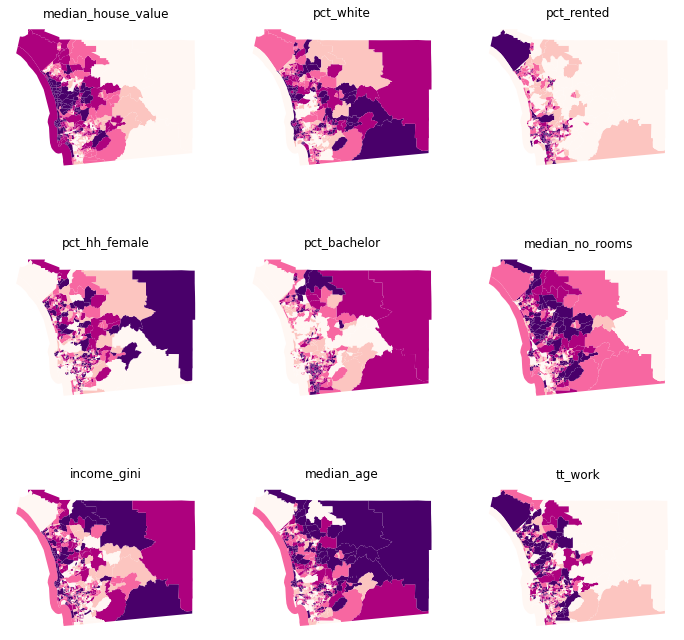

In [5]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    db.plot(column=col, ax=ax, scheme='Quantiles', 
            linewidth=0, cmap='RdPu')
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

Many visual patterns jump out from the maps, revealing both commonalities as
well as differences across the spatial distributions of the individual variables.
Several variables tend to increase in value from the east to the west
(`pct_rented`, `median_house_value`, `median_no_rooms`, and `tt_work`) while others
have a spatial trend in the opposite direction (`pct_white`, `pct_hh_female`,
`pct_bachelor`, `median_age`). This is actually desirable; when variables have
different spatial distributions, each variable to contributes distinct 
information to the profiles of each cluster. However, if all variables display very similar 
spatial patterns, the amount of useful information across the maps is 
actually smaller than it appears, so cluster profiles may be much less useful as well.
It is also important to consider whether the variables display any
spatial autocorrelation, as this will affect the spatial structure of the
resulting clusters. 

Recall from chapter XXX that Moran's I is a commonly used
measure for global spatial autocorrelation. 
Let us get a quick sense to what
extent this is present in our dataset.
First, we need to build a spatial weights matrix that encodes the spatial
relationships in our San Diego data. We will start with queen contiguity:

In [6]:
w = Queen.from_dataframe(db)

As we have seen before, `w` does not contain any islands:

In [7]:
w.islands

[]

Now let's calculate Moran's I for the variables being used. This will measure
the extent to which each variable contains spatial structure:

In [8]:
# Set seed for reproducibility
numpy.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [Moran(db[variable], w) for variable in cluster_variables]
# Display on table
table = pandas.DataFrame([(variable, res.I, res.p_sim) \
                          for variable,res \
                          in zip(cluster_variables, mi_results)
                         ], columns=['Variable', "Moran's I", 'P-value']
                        )\
              .set_index('Variable')
table

,Moran's I,P-value
Variable,,
median_house_value,0.646618,0.001
pct_white,0.602079,0.001
pct_rented,0.451372,0.001
pct_hh_female,0.282239,0.001
pct_bachelor,0.433082,0.001
median_no_rooms,0.538996,0.001
income_gini,0.295064,0.001
median_age,0.381440,0.001
tt_work,0.102748,0.001


Each of the variables displays significant positive spatial autocorrelation,
suggesting that Tobler's law is alive and well in the socioeconomic geography of San
Diego County. This means we also should expect the clusters we find will have
a non random spatial distribution. In particular, we would expect clusters to have
a modest amount of spatial coherence in addition to the coherence in their profiles,
since there is strong positive autocorrelation in all of the input variables.

Spatial autocorrelation only describes relationships between a single observation at a time.
So, the fact that all of the clustering variables are positively autocorrelated does not tell us 
about the way the attributes covary over space. For that, we need to consider the
spatial correlation between variables. Here, we will measure this using the
bivariate correlation in the maps of covariates themselves.

Given the 9 maps, there are 36 pairs of maps that must be compared. This is too 
many maps to process visually, so we can turn to an alternative tool to
explicitly focus on the bivariate relations between each pair of attributes.

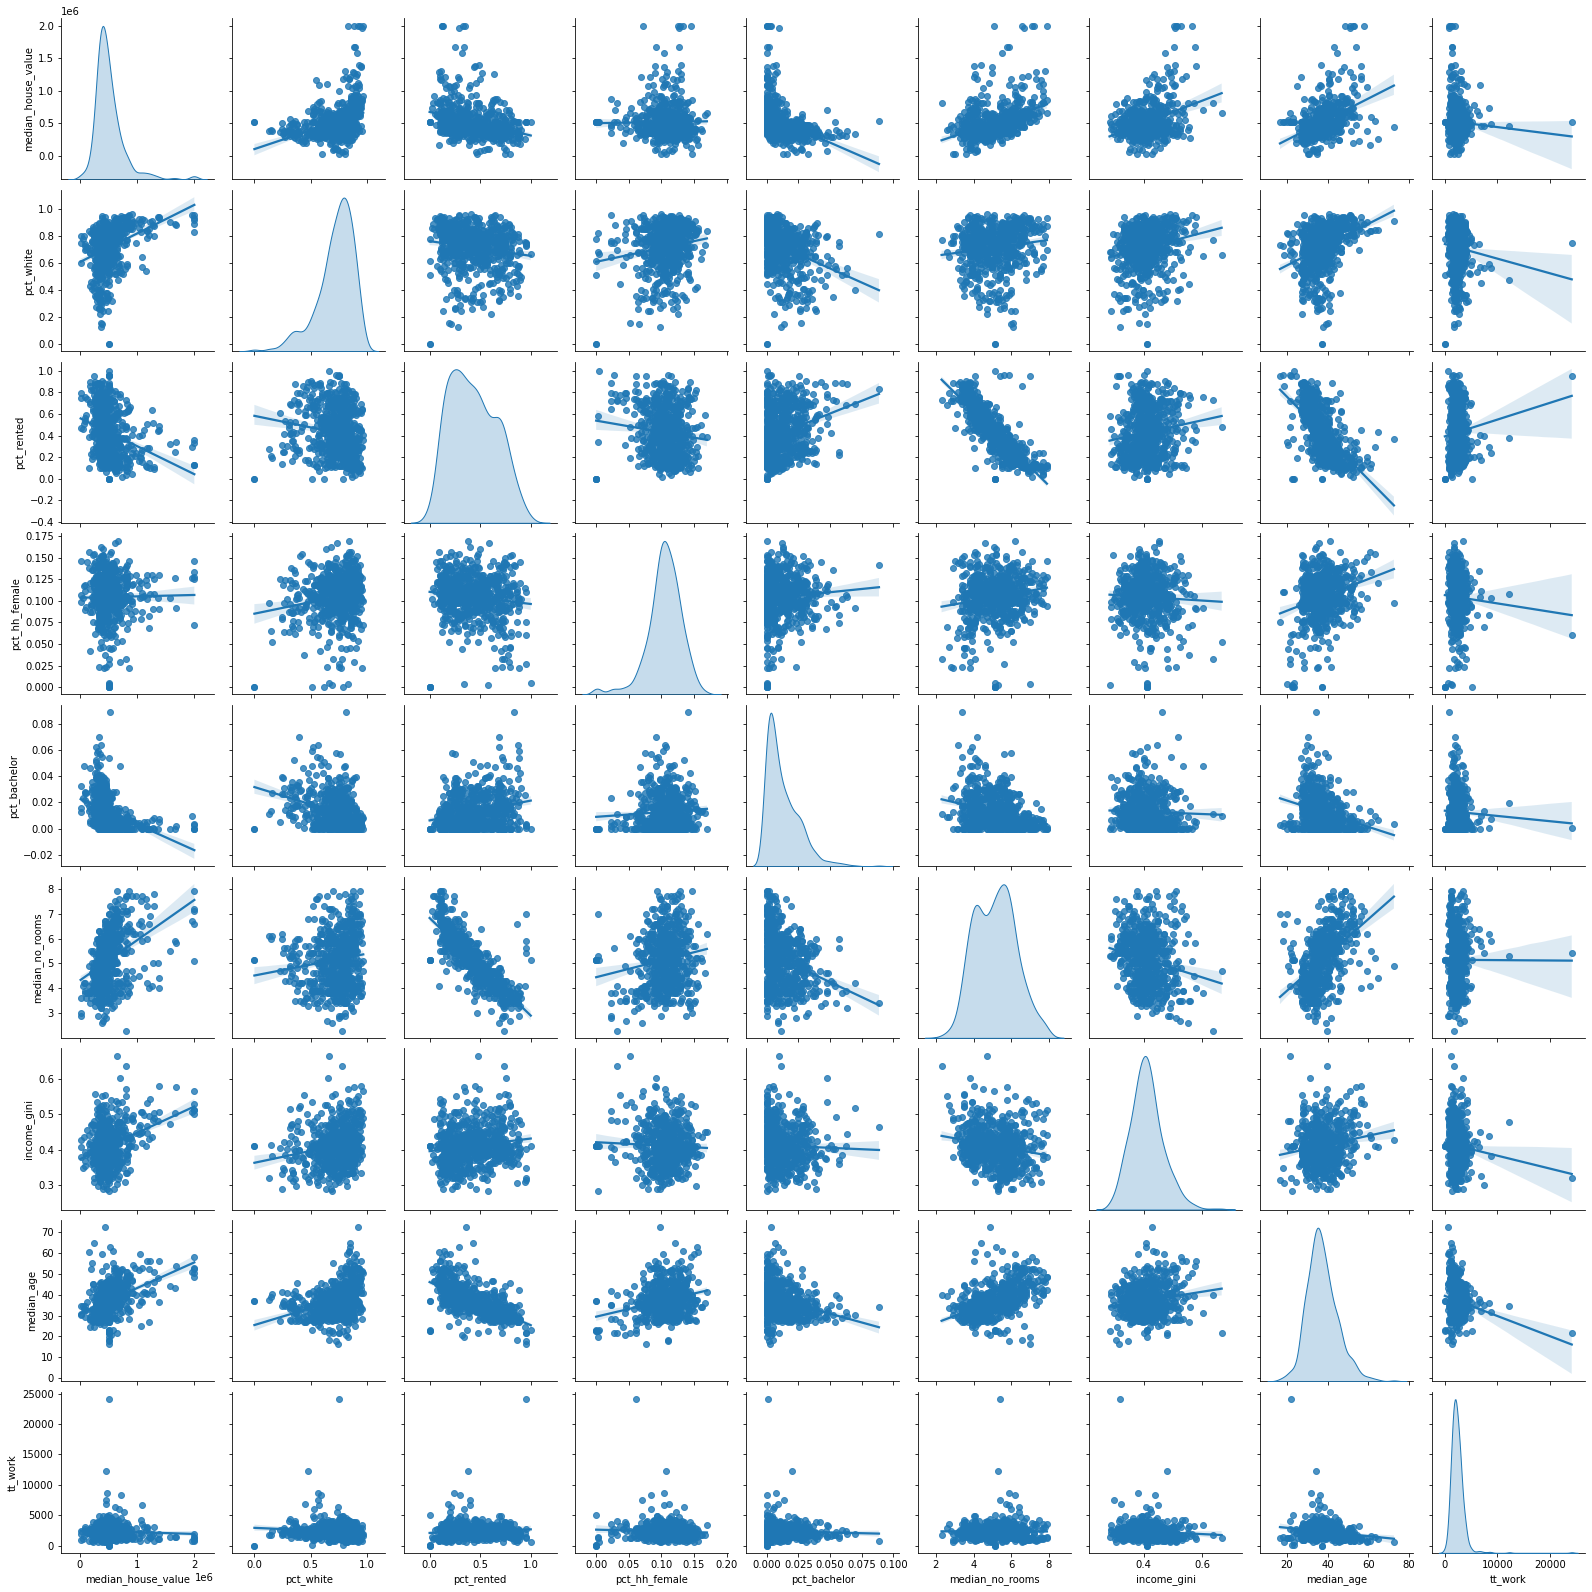

In [9]:
_ = seaborn.pairplot(db[cluster_variables], kind='reg', diag_kind='kde')

Two different types of plots are contained in the scatterplot matrix. On the
diagonal are the density functions for the nine attributes. These allow for an
inspection of the overall morphology of the attribute's value distribution.
Examining these we see that our selection of variables includes those that are
negatively skewed (`pct_white` and `pct_hh_female`) as well as positively skewed
(`median_house_value`, `pct_bachelor`, and `tt_work`).

The second type of visualization lies in the off-diagonal cells of the matrix; 
these are bi-variate scatterplots. Each cell shows the association between one
pair of variables. Several of these cells indicate positive linear
associations (`median_age` Vs. `median_house_value`, `median_house_value` Vs. `median_no_rooms`)
while other cells display negative correlation (`median_house_value` Vs. `pct_rented`,
`median_no_rooms` Vs. `pct_rented`, and `median_age` Vs. `pct_rented`). The one variable
that tends to have consistenty weak association with the other variables is
`tt_work`, and in part this appears to reflect its rather concentrated 
distribution as seen on the lower right diagonal corner cell.

## Geodemographic Clusters in San Diego Census Tracts

We now will move
beyond the implicitly bi-variate focus to consider the full multidimensional
nature of this data set. Geodemographic analysis is a form of multivariate
clustering where the observations represent geographical areas. The output
of these clusterings is nearly always mapped. Altogether, these methods use
multivariate clustering algorithms to construct a known number of
clusters ($k$), where the number of clusters is typically much smaller than the 
number of observations to be clustered. Each cluster is given a unique label,
and these labels are mapped. Using the clusters' profile and label, the map of 
labels can be interpreted to get a sense of the spatial distribution of 
sociodemographic traits. The power of (geodemographic) clustering comes
from taking statistical variation across several dimensions and compressing it
into a single categorical one that we can visualize through a map. To
demonstrate the variety of approaches in clustering, we will show two
distinct but very popular clustering algorithms: k-means and Ward's hierarchical method.

### K-means

K-means is probably the most widely used approach to
cluster a dataset. The algorithm groups observations into a
prespecified number of clusters so that that each observation is
closer to the mean of its own cluster than it is to the mean of any other cluster.
The k-means problem is solved by iterating between an assignment step and an update step. 
First, all observations are randomly assigned one of the $k$ labels. Next, the 
multivariate mean over all covariates is calculated for each of the clusters.
Then, each observation is reassigned to the cluster with the closest mean. 
If the observation is already assigned to the cluster whose mean it is closest to,
the observation remains in that cluster. This assignment-update process continues
until no further reassignments are necessary.

The nature of this algorithm requires us to select the number of clusters we 
want to create. The right number of clusters is unknown in practice. For
illustration, we will use $k=5$ in the `KMeans` implementation from
`scikit-learn`. To proceed, we first create a `KMeans` clusterer:

In [10]:
# Initialise KMeans instance
kmeans = KMeans(n_clusters=5)

Next, we call the `fit` method to actually apply the k-means algorithm to our data:

In [11]:
# Set the seed for reproducibility
numpy.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db[cluster_variables])

Now that the clusters have been assigned, we can examine the label vector, which 
records the cluster to which each observation is assigned:

In [12]:
k5cls.labels_

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1, 2,
       3, 1, 4, 0, 1, 1, 1, 4, 1, 4, 1, 4, 4, 1, 0, 4, 4, 4, 1, 4, 4, 1,
       4, 4, 4, 0, 1, 1, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1,
       4, 4, 0, 1, 1, 1, 4, 4, 1, 1, 4, 4, 1, 4, 0, 4, 0, 4, 4, 0, 1, 1,
       1, 0, 3, 3, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 4, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 4, 1, 4, 2, 4, 0, 4, 4, 4, 4, 1, 4, 4, 1, 0, 4, 4, 4, 4,
       4, 1, 1, 1, 1, 4, 4, 1, 0, 4, 4, 4, 1, 4, 4, 0, 0, 0, 1, 2, 2, 2,
       4, 4, 4, 4, 4, 2, 0, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 0, 3, 1,
       1, 1, 1, 0, 4, 1, 4, 4, 4, 4, 1, 1, 4, 4, 0, 1, 4, 4, 4, 1, 1, 1,
       1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 4, 1,
       1, 4, 1, 4, 1, 1, 0, 4, 0, 4, 0, 3, 4, 1, 2, 0, 4, 1, 1, 4, 2, 1,
       4, 4, 1, 0, 0, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 4, 1, 0, 0, 1, 1, 4,
       4, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 0, 0, 4, 4, 1, 4, 4, 4, 1, 0, 4,
       4, 1, 4, 4, 4, 4, 4, 4, 1, 1, 4, 1, 1, 1, 4,

In this case, the second and third observations are assigned to cluster 4, while
the fourth and fifth observations have been placed in cluster 0. It is important
to note that the integer labels should be viewed as denoting membership only &mdash;
the numerical differences between the values for the labels are meaningless.
The profiles of the various clusters must be further explored by looking
at the values of each dimension. 

But, before we do that, let's make a map.

### Spatial Distribution of Clusters

Having obtained the cluster labels, we can display the spatial
distribution of the clusters by using the labels as the categories in a
choropleth map. This allows us to quickly grasp any sort of spatial pattern the 
clusters might have. Since clusters represent areas with similar
characteristics, mapping their labels allows to see to what extent similar areas tend
to have similar locations.
Thus, this gives us one map that incorporates the information of from all nine covariates.

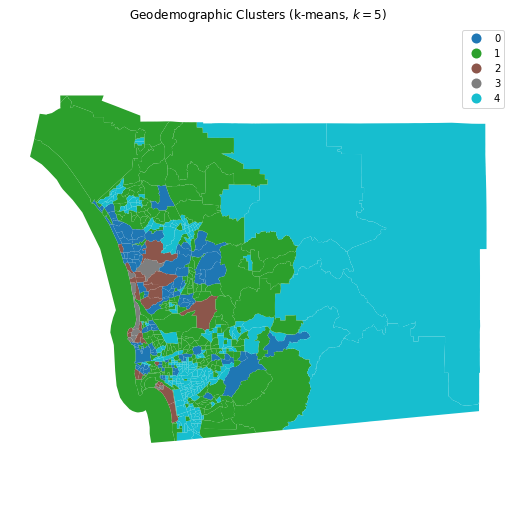

In [13]:
# Assign labels into a column
db['k5cls'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Geodemographic Clusters (k-means, $k=5$)')
# Display the map
plt.show()

The map provides a useful view of the clustering results; it allows for
a visual inspection of the extent to which Tobler's first law of geography is
reflected in the multivariate clusters. Recall that the law implies that nearby
tracts should be more similar to one another than tracts that are geographically
more distant from each other. We can see evidence of this in
our cluster map, since clumps of tracts with the same color emerge. However, this
visual inspection is obscured by the complexity of the underlying spatial
units. Our eyes are drawn to the larger polygons in the eastern part of the
county, giving the impression that cluster 1 is the dominant cluster. While this
seems to be true in terms of land area (and we will verify this below), there is
more to the cluster pattern than this. Because the tract polygons are all 
different sizes and shapes, we cannot solely rely on our eyes to interpret 
the spatial distribution of clusters.

### Statistical Analysis of the Cluster Map

To complement the geovisualization of the clusters, we can explore the
statistical properties of the cluster map. This process allows us to delve
into what observations are part of each cluster and what their
characteristics are.
This gives us the profile of each cluster so we can interpret the meaning of the
labels we've obtained. We can start, for example, by
considering cardinality, or the count of observations in each cluster:

In [14]:
# Group data table by cluster label and count observations
k5sizes = db.groupby('k5cls').size()
k5sizes

k5cls
0    102
1    240
2     25
3      9
4    252
dtype: int64

And we can get a visual representation of cardinality as well:

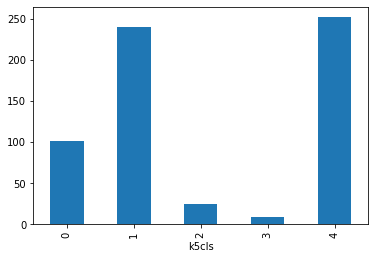

In [15]:
_ = k5sizes.plot.bar()

There are substantial differences in the sizes of the five clusters, with two very
large clusters (0, 3), one medium sized cluster (2), and two small clusters (1,
4). Cluster 3 is the largest when measured by the number of assigned tracts.
This confirms our intuition from the map above, where we got the visual impression
that tracts in cluster 3 seemed to have the largest area. Let's see if this is 
the case. To do so we can use the `dissolve` operation in `geopandas`, which 
combines all tracts belonging to each cluster into a single
polygon object. After we have dissolved all the members of the clusters,
we report the total land area of the cluster:

In [16]:
# Dissolve areas by Cluster, aggregate by summing, and keep column for area
areas = db.dissolve(by='k5cls', aggfunc='sum')['area_sqm']
areas

k5cls
0     639.178767
1    4137.809886
2     245.345027
3      63.002389
4    6636.436573
Name: area_sqm, dtype: float64

And, to show this visually:

<AxesSubplot:xlabel='k5cls'>

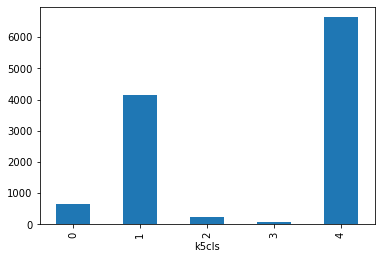

In [17]:
areas.plot.bar()

Our visual impression is confirmed: cluster 3 contains tracts that
together comprise 6,636 square kilometers (approximately 2562 square miles),
which accounts for over half of the total land area in the county:

In [18]:
areas[3]/areas.sum()

0.0053748175341845955

Let's move on to build the profiles for each cluster. Again, the profiles is what
provides the conceptual shorthand, moving from the arbitrary label to a meaningful
collection of observations with similar attributes. To build a basic profile, we can
compute the means of each of the attributes in every cluster:

In [19]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their mean
k5means = db.groupby('k5cls')[cluster_variables].mean()
k5means.T.round(3)

k5cls,0,1,2,3,4
median_house_value,736881.373,500787.575,1168004.000,1876867.222,326728.968
pct_white,0.805,0.722,0.841,0.909,0.658
pct_rented,0.325,0.406,0.288,0.251,0.512
pct_hh_female,0.104,0.102,0.107,0.117,0.106
pct_bachelor,0.004,0.010,0.002,0.002,0.020
median_no_rooms,5.733,5.294,6.020,6.422,4.627
income_gini,0.430,0.401,0.474,0.520,0.402
median_age,41.600,37.211,44.436,50.544,34.246
tt_work,2336.284,2539.429,2182.000,1237.778,2187.754


We see that cluster 4, for example, is composed of tracts that have
the highest average `median_house_value`, and also the highest level of inequality
(`income_gini`); and cluster 4 contains an older population (`median_age`)
who tend to live in housing units with more rooms (`median_no_rooms`).
Average values, however, can hide a great deal of detail and, in some cases,
give wrong impressions about the type of data distribution they represent. To
obtain more detailed profiles, we can use the `describe` command in `pandas`, 
after grouping our observations by their clusters:

In [20]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their descriptive summary
k5desc = db.groupby('k5cls')[cluster_variables].describe()
# Loop over each cluster and print a table with descriptives
for cluster in k5desc.T:
    print('\n\t---------\n\tCluster %i'%cluster)
    print(k5desc.T[cluster].unstack())


	---------
	Cluster 0
                    count           mean           std            min  \
median_house_value  102.0  736881.372549  87489.733180  621600.000000   
pct_white           102.0       0.805041      0.126212       0.476693   
pct_rented          102.0       0.325356      0.205539       0.019410   
pct_hh_female       102.0       0.103719      0.024251       0.022453   
pct_bachelor        102.0       0.004370      0.006314       0.000000   
median_no_rooms     102.0       5.733333      1.259761       2.300000   
income_gini         102.0       0.429732      0.067163       0.300900   
median_age          102.0      41.600000      6.418306      21.500000   
tt_work             102.0    2336.284314   1253.010603     771.000000   

                              25%            50%            75%            max  
median_house_value  663400.000000  708200.000000  809225.000000  930600.000000  
pct_white                0.752426       0.853539       0.895305       0.966185  
pct

However, this approach quickly gets out of hand: more detailed profiles can simply
return to an unwieldy mess of numbers. A better approach to constructing
cluster profiles is be to draw the distributions of cluster members' data.
To do this we need to "tidy up" the dataset. A tidy dataset ([Wickham,
2014](https://www.jstatsoft.org/article/view/v059i10)) is one where every row is
an observation, and every column is a variable. Thus, a few steps are required 
to tidy up our labelled data:

In [21]:
# Index db on cluster ID
tidy_db = db.set_index('k5cls')
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db.head()

,k5cls,Attribute,Values
0,0,median_house_value,732900.000000
1,0,pct_white,0.916988
2,0,pct_rented,0.373913
3,0,pct_hh_female,0.052896
4,0,pct_bachelor,0.000000


Now we are ready to plot. Below, we'll show the distribution of each cluster's values
for each variable. This gives us the full distributional profile of each cluster:

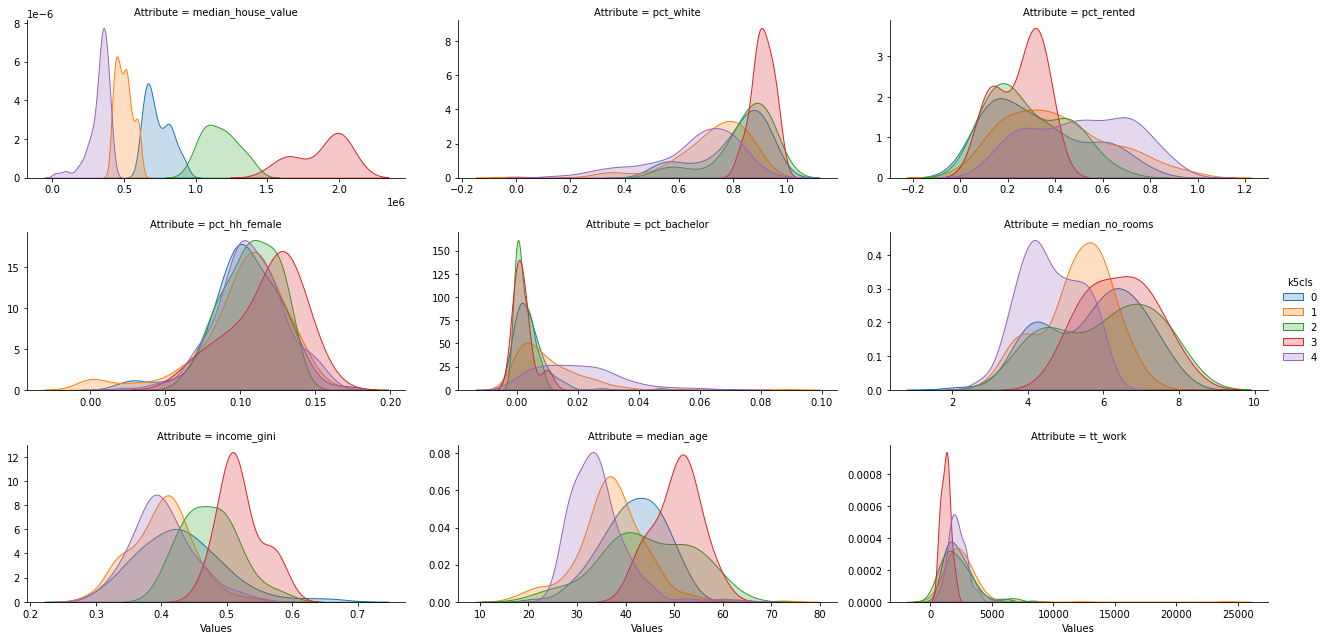

In [22]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', hue='k5cls', \
                  sharey=False, sharex=False, aspect=2, col_wrap=3)
# Build the plot from `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()

This allows us to see that, while some attributes such as the percentage of
female households (`pct_hh_female`) display largely the same distribution for
each cluster, others paint a much more divided picture (e.g. `median_house_value`).
Taken altogether, these graphs allow us to start delving into the multidimensional 
complexity of each cluster and the types of areas behind them.

## Hierarchical Clustering

As mentioned above, k-means is only one clustering algorithm. There are
plenty more. In this section, we will take a similar look at the San Diego
dataset using another staple of the clustering toolkit: agglomerative
hierarchical clustering (AHC). Agglomerative clustering works by building a hierarchy of
clustering solutions that starts with all singletons (each observation is a single
cluster in itself) and ends with all observations assigned to the same cluster.
These extremes are not very useful in themselves. But, in between, the hierarchy
contains many distinct clustering solutions with varying levels of detail. 
The intuition behind the algorithm is also rather straightforward: 

1) begin with everyone as part of its own cluster; 
2) find the two closest observations based on a distance metric (e.g. euclidean); 
3) join them into a new cluster; 
4) repeat steps 2) and 3) until reaching the degree of aggregation desired. 

The algorithm is thus called "agglomerative"
because it starts with individual clusters and "agglomerates" them into fewer
and fewer clusters containing more and more observations each. Also, like with 
k-means, AHC does require the user to specify a number of clusters in advance.
This is because, following from the mechanism the method has to build clusters, 
AHC can provide a solution with as many clusters as observations ($k=n$),
or with a only one ($k=1$).

Enough of theory, let's get coding! In Python, AHC can be run
with `scikit-learn` in very much the same way we did for k-means in the previous
section. In this case, we use the `AgglomerativeClustering` class and again 
use the `fit` method to actually apply the clustering algorithm to our data:

In [23]:
# Set seed for reproducibility
numpy.random.seed(0)
# Iniciate the algorithm
model = AgglomerativeClustering(linkage='ward', n_clusters=5)
# Run clustering
model.fit(db[cluster_variables])
# Assign labels to main data table
db['ward5'] =model.labels_

As above, we can check the number of observations that fall within each cluster:

In [24]:
ward5sizes = db.groupby('ward5').size()
ward5sizes

ward5
0    141
1    233
2    222
3     23
4      9
dtype: int64

Further, we can check the simple average profiles of our clusters:

In [25]:
ward5means = db.groupby('ward5')[cluster_variables].mean()
ward5means.T.round(3)

ward5,0,1,2,3,4
median_house_value,703765.957,473097.931,316161.712,1184173.913,1876867.222
pct_white,0.799,0.706,0.656,0.842,0.909
pct_rented,0.327,0.420,0.523,0.293,0.251
pct_hh_female,0.105,0.102,0.106,0.107,0.117
pct_bachelor,0.005,0.011,0.021,0.002,0.002
median_no_rooms,5.695,5.222,4.575,5.939,6.422
income_gini,0.421,0.401,0.403,0.478,0.520
median_age,41.535,36.389,34.062,44.261,50.544
tt_work,2305.206,2556.399,2172.563,2201.913,1237.778


And again, we can create a plot of the profiles' distributions (after properly 
tidying up):

In [26]:
# Index db on cluster ID
tidy_db = db.set_index('ward5')
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db.head()

,ward5,Attribute,Values
0,0,median_house_value,732900.000000
1,0,pct_white,0.916988
2,0,pct_rented,0.373913
3,0,pct_hh_female,0.052896
4,0,pct_bachelor,0.000000


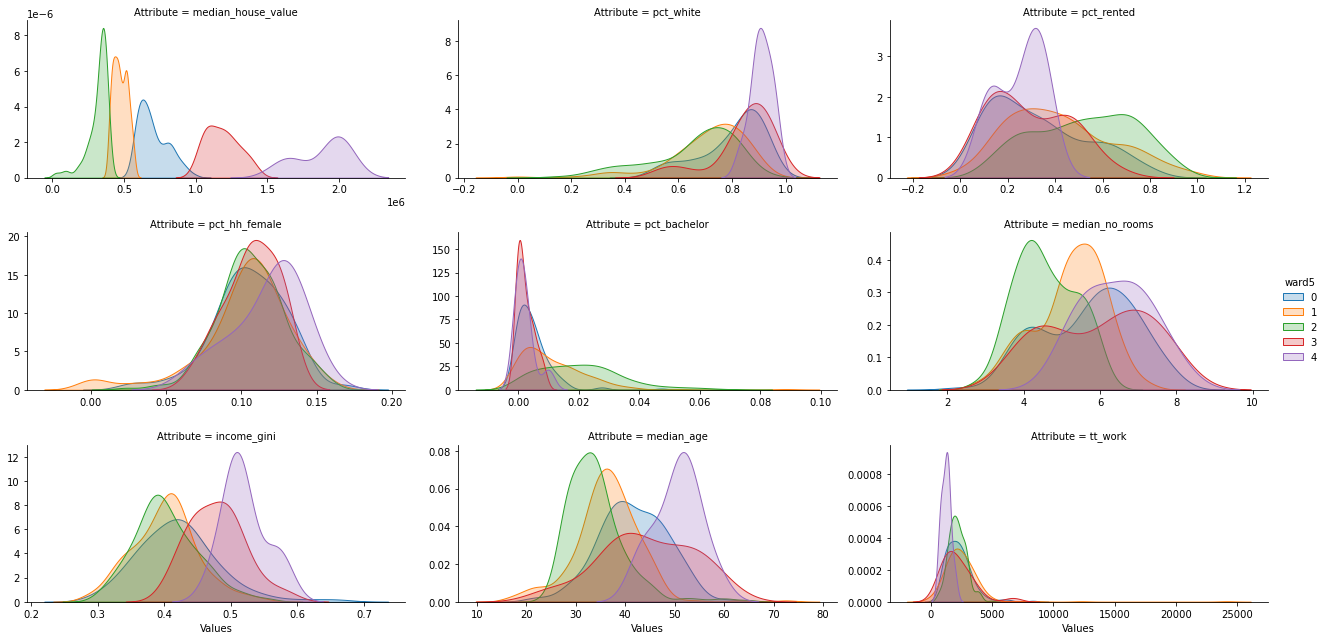

In [27]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', hue='ward5', \
                  sharey=False, sharex=False, aspect=2, col_wrap=3)
# Build the plot as a `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()

For the sake of brevity, we will not spend much time on the plots above.
However, the interpretation is analogous to that of the k-means example.

On the spatial side, we can explore the geographical dimension of the
clustering solution by making a map the clusters:

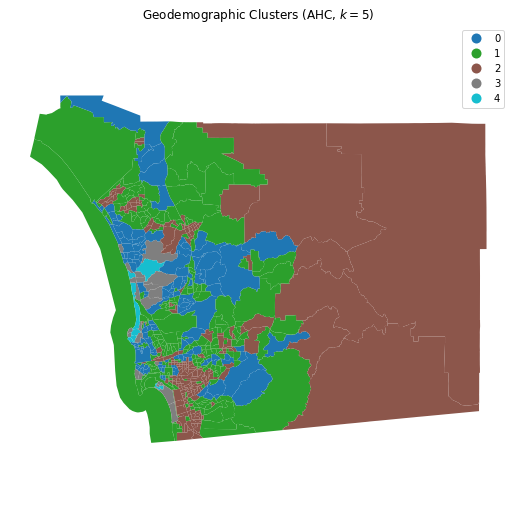

In [28]:
db['ward5'] =model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward5', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('Geodemographic Clusters (AHC, $k=5$)')
# Display the map
plt.show()

And, to make comparisons simpler, we can display both the k-means and the AHC
results side by side:

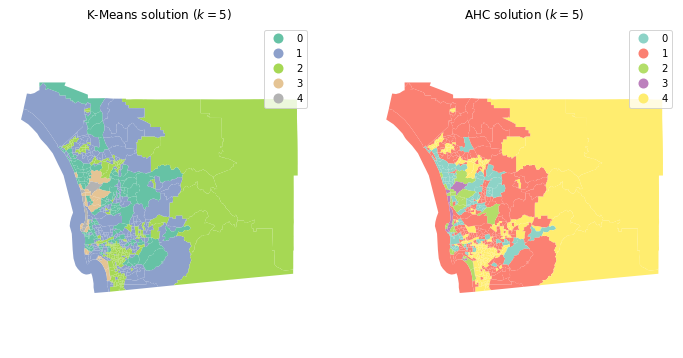

In [29]:
db['ward5'] =model.labels_
# Setup figure and ax
f, axs = plt.subplots(1, 2, figsize=(12, 6))

ax = axs[0]
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward5', categorical=True, cmap='Set2', 
        legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
ax.axis('equal')
# Add title
ax.set_title('K-Means solution ($k=5$)')

ax = axs[1]
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='k5cls', categorical=True, cmap='Set3',
        legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
ax.axis('equal')
# Add title
ax.set_title('AHC solution ($k=5$)')

# Display the map
plt.show()

While we must remember our earlier caveat about how irregular polygons can 
baffle our visual intuition, a closer visual inspection of the cluster geography
suggests a clear pattern: although they are not identical, both clusterings capture
very similar overall spatial structure. Furthermore, both solutions slightly violate 
Tobler's law, since all of the clusters have disconnected components. The five
multivariate clusters in each case are actually composed of many disparate 
geographical areas, strewn around the map according only to the structure of the
data and not its geography. That is, in order to travel to
every tract belonging to a cluster, we would have to journey through
other clusters as well.

## Spatially Constrained Hierarchical Clustering

Fragmented clusters are not intrinsically invalid, particularly if we are
interested in exploring the overall structure and geography of multivariate
data. However, in some cases, the application we are interested in might
require that all the observations in a class be spatially connected. For
example, when detecting communities or neighborhoods (as is sometimes needed when
drawing electoral or census boundaries), they are nearly always distinct 
self-connected areas, unlike our clusters shown above. To ensure that clusters are
not spatially fragmented, we turn to regionalization.

Regionalization methods are clustering techniques that impose a spatial constraints
on clusters. In other words, the result of a regionalization algorithm contains clusters with
areas that are geographically coherent, in addition to having coherent data profiles. 
Effectively, this means that regionalization methods construct clusters that are 
all internally-connected; these are the *regions*. Thus, a regions' members must
be geographically *nested* within the region's boundaries.

This type of nesting relationship is easy to identify
in the real world. For example, counties nest within states, or, in the UK, 
local super output areas (LSOAs) nest within middle super output areas (MSOAs). 
The difference between these real-world nestings and the output of a regionalization
algorithm is that the real-world nestings are aggregated according to administrative principles, but regions' members are aggregated according to a statistical technique. In the same manner as the
clustering techniques explored above, these regionalization methods aggregate 
observations that are similar in their covariates; the profiles of regions are useful
in a similar manner as the profiles of clusters. But, in regionalization, the 
clustering is also spatially constrained, so the region profiles and members will
likely be different from the unconstrained solutions.

As in the non-spatial case, there are many different regionalization methods.
Each has a different way to measure (dis)similarity, how the similarity is used
to assign labels, how these labels are iteratively adjusted, and so on. However,
as with clustering algorithms, regionalization methods all share a few common traits.
In particular, they all take a set of input attributes and a representation of 
spatial connectivity in the form of a binary spatial weights matrix. Depending 
on the algorithm, they also require the desired number of output regions. For
illustration, we will take the AHC algorithm we have just used above, and apply 
an additional spatial constraint. In `scikit-learn`, this is done using
our spatial weights matrix as a `connectivity` option.
This will force the agglomerative algorithm to only allow observations to be grouped
in a cluster if they are also spatially connected:

In [30]:
numpy.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',
                                            connectivity=w.sparse,
                                            n_clusters=5)
model.fit(db[cluster_variables])

AgglomerativeClustering(connectivity=<628x628 sparse matrix of type '<class 'numpy.float64'>'
	with 4016 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

Let's inspect the output:

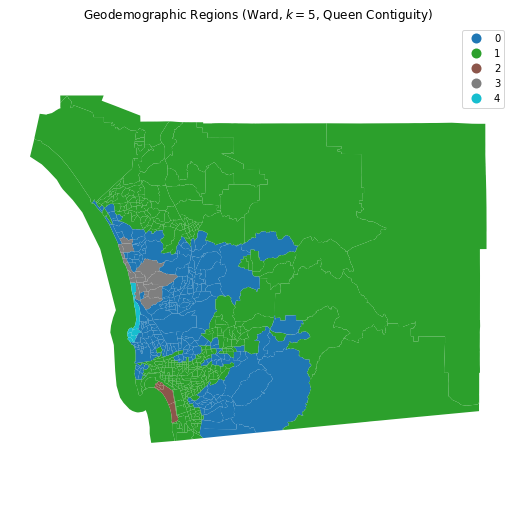

In [31]:
db['ward5wq'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward5wq', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Geodemographic Regions (Ward, $k=5$, Queen Contiguity)')
# Display the map
plt.show()


Introducing the spatial constraint results in fully-connected clusters with much
more concentrated spatial distributions. From an initial visual impression, it might
appear that our spatial constraint has been violated: there are tracts for both cluster 0 and
cluster 1 that appear to be disconnected from the rest of their clusters.
However, closer inspection reveals that each of these tracts is indeed connected
to another tract in its own cluster by very narrow shared boundaries.

### Changing the spatial constraint

The spatial constraint in regionalization algorithms is structured by the
spatial weights matrix we use. An interesting
question is thus how the choice of weights influences the final region structure.
Fortunately, we can directly explore the impact that a change in the spatial weights matrix has on
regionalization. To do so, we use the same attribute data
but replace the Queen contiguity matrix with a spatial k-nearest neighbor matrix,
where each observation is connected to its four nearest observations, instead
of those it touches.

In [32]:
w = KNN.from_dataframe(db, k=4)

With this matrix connecting each tract to the four closest tracts, we can run 
another AHC regionalization:

In [33]:
numpy.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',
                                            connectivity=w.sparse,
                                            n_clusters=5)
model.fit(db[cluster_variables])

AgglomerativeClustering(connectivity=<628x628 sparse matrix of type '<class 'numpy.float64'>'
	with 2512 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

And plot the final regions:

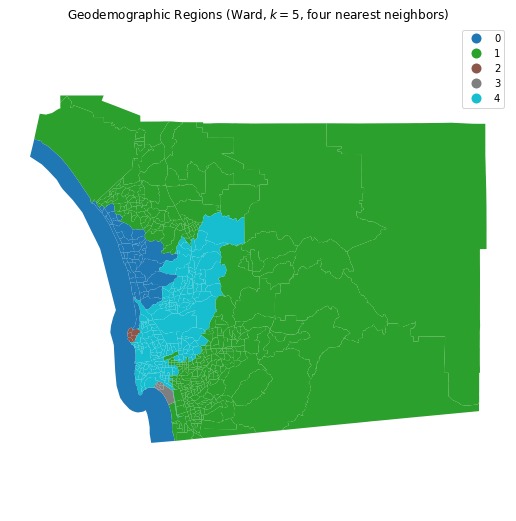

In [34]:
db['ward5wknn'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward5wknn', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('Geodemographic Regions (Ward, $k=5$, four nearest neighbors)')
# Display the map
plt.show()

Even though we have specified a spatial constraint, the constraint applies to the
connectivity graph modeled by our weights matrix. Therefore, using k-nearest neighbors
to constrain the agglomerative clustering may not result in regions that are connected
according to a different connectivity rule, such as the queen contiguity rule used
in the previous section. However, the regionalization here is fortuitous; even though
we used the 4-nearest tracts to constrain connectivity, all but one of the clusters, 
cluster 4, is *also* connected according to our earlier queen contiguity rule. 

At first glance, this may seem counter-intuitive. We did specify the spatial
constraint, so our initial reaction is that the connectivity constraint is
violated. However, this is not the case, since the constraint applies to the
k-nearest neighbor graph, not the queen contiguity graph. Therefore, since tracts
in this solution are considered as connected to their four closest neighbors,
clusters can "leapfrog" over one another. Thus, it is important to recognize that
the apparent spatial structure of regionalizations will depend on how the 
connectivity of observations is modeled. 

## Conclusion

Overall, clustering and regionalization are two complementary tools to reduce the
complexity in multivariate data and build better understandings of the spatial structure 
of data. Often, there is simply too much data to examine every variables' map and its
relation to all other variable maps. 
Thus, clustering reduces this complexity into a single conceptual shorthand by which 
people can easily describe complex and multifaceted data. 
Clustering constructs groups of observations (called *clusters*)
with coherent *profiles*, or distinct and internally-consistent 
distributional/descriptive characteristics. 
These profiles are the conceptual shorthand, since members of each cluster should
be more similar to the cluster at large than they are to any other cluster. 
Many different clustering methods exist; they differ on how the "cluster at large" 
is defined, and how "similar" members must be to clusters, or how these clusters
are obtained.
Regionalization is a special kind of clustering with an additional geographic requirement. 
Observations should be grouped so that each spatial cluster,
or *region*, is spatially-coherent as well as data-coherent. 
Thus, regionalization is often concerned with connectivity in a contiguity 
graph for data collected in areas; this ensures that the regions that are identified
are fully internally-connected. 
However, since many regionalization methods are defined for an arbitrary connectivity structure,
these graphs can be constructed according to different rules as well, such as the k-nearest neighbor graph. 

In this chapter, we discussed the conceptual basis for clustering and regionalization, 
as well showing why clustering is done. 
Further, we have shown how to build clusters using spatial data science packages, 
and how to interrogate the meaning of these clusters as well.
More generally, clusters are often used in predictive and explanatory settings, 
in addition to being used for exploratory analysis in their own right.
Clustering and regionalization are intimately related to the analysis of spatial autocorrelation as well,
since the spatial structure and covariation in multivariate spatial data is what
determines the spatial structure and data profile of discovered clusters or regions.
Thus, clustering and regionalization are essential tools for the spatial data scientist.

## Questions

1. What disciplines employ regionalization? Cite concrete examples for each discipline you list.
2. Contrast and compare  the concepts of *clusters* and *regions*?
3. In evaluating the quality of the solution to a regionalization problem, how might traditional measures of cluster evaluation be used? In what ways might those measures be limited and need expansion to consider the geographical dimensions of the problem?
4. Discuss the implications for the processes of regionalization that follow from the number of *connected components* in the spatial weights matrix that would be used.
5. True or false: The average silhouette score for a spatially constrained solution will be no larger than the average silhouette score for an unconstrained solution. Why, or why not? (add reference and  or explain silhouette)
6. Consider two possible weights matrices for use in a spatially constrained clustering problem. Both form a single connected component for all the areal units. However, they differ in the sparsity of their adjacency graphs (think Rook being more dense than Queen graphs). 
    a. How might the sparsity of the weights matrix affect the quality of the clustering solution?
    b. Using `pysal.lib.weights.higher_order`, construct a second-order adjacency matrix of the weights matrix used in this chapter. 
    c. Compare the `pct_nonzero` for both matrices. 
    d. Rerun the analysis from this chapter using this new second-order weights matrix. What changes? 
7. The idea of spatial dependence, that near things tend to be more related than distant things, is an extensively-studied property of spatial data. How might solutions to clustering and regionalization problems change if dependence is very strong and positive? very weak? very strong and negative? 
8. In other areas of spatial analysis, multilevel models [1] recognize that sometimes, geographical regions are more similar internally than they are externally. That is, two observations in the same region are probably more similar than two observations in different regions. If this kind of dependence is very strong, what would happen to clustering and regionalization solutions?
9. Using a spatial weights object obtained as `w = pysal.lib.weights.lat2W(20,20)`, what are the number of unique ways to partition the graph into 20 clusters of 20 units each, subject to each cluster being a connected component? What are the unique number of possibilities for `w = pysal.lib.weights.lat2W(20,20, rook=False)` ?